<a href="https://colab.research.google.com/github/ZzzzzzT233/linearRegression/blob/main/04_hedonic_pricing/04_hedonic_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [ ]:
! git clone https://github.com/ZzzzzzT233/linearRegression

fatal: destination path 'linearRegression' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = pd.read_csv('linearRegression/04_hedonic_pricing/airbnb_hw.csv')

print(df.dtypes, '\n')


print(df.head(),'\n')

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object 

    Host Id Host Since                                Name Neighbourhood   \
0   5162530        NaN     1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN     Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN                Sunny Room in Harlem      Manhattan   
3       500  6/26/2008  Gorgeous 1 BR with Private Balcony      Manhattan   
4       500  6/26/2008            Trendy Times Square Loft      Manhattan   

  Property Type  Review Sco

In [ ]:
df["Price"] = df["Price"].str.replace(",", "")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
print("Total Missings:", sum(df["Price"].isnull()),"\n")
print(df.describe(), '\n')

Total Missings: 0 

            Host Id  Review Scores Rating (bin)       Zipcode          Beds  \
count  3.047800e+04                22155.000000  30344.000000  30393.000000   
mean   1.273171e+07                   90.738659  10584.854831      1.530089   
std    1.190270e+07                    9.059519    921.299397      1.015359   
min    5.000000e+02                   20.000000   1003.000000      0.000000   
25%    2.701298e+06                   85.000000  10017.000000      1.000000   
50%    8.551693e+06                   90.000000  10065.000000      1.000000   
75%    2.120617e+07                  100.000000  11216.000000      2.000000   
max    4.303307e+07                  100.000000  99135.000000     16.000000   

       Number of Records  Number Of Reviews         Price  \
count            30478.0       30478.000000  30478.000000   
mean                 1.0          12.018735    163.589737   
std                  0.0          21.980703    197.785454   
min                  1.0

<Axes: >

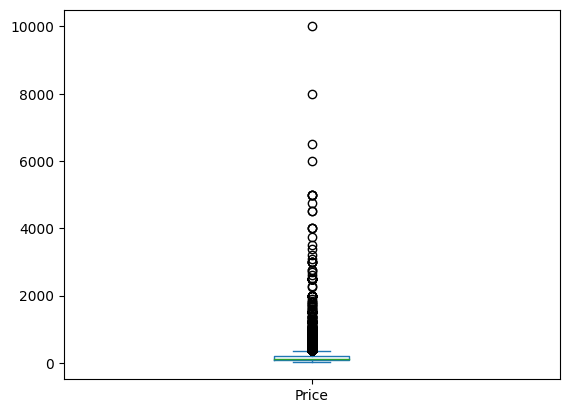

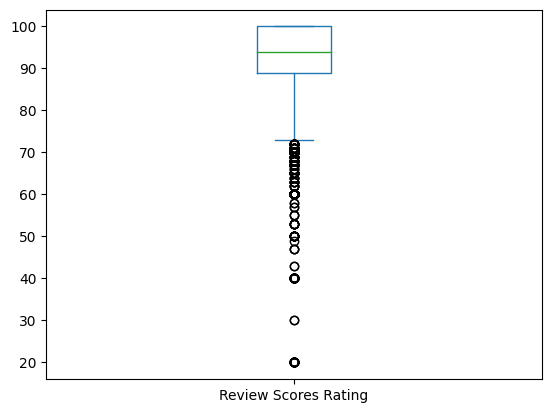

In [ ]:
def winsorize(x):
    # Convert from pd to np, if necessary:
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)

df.loc[:,['Price']].plot.box()
df.loc[:,['Review Scores Rating']].plot.box()

<Axes: >

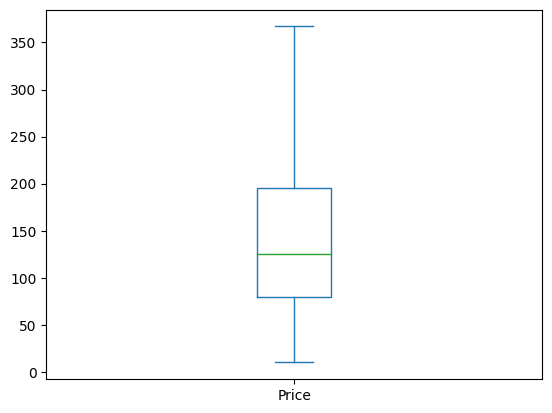

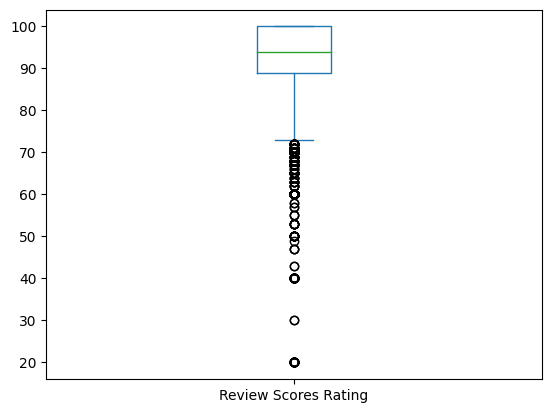

In [ ]:
df.loc[:,['Price']] = df.loc[:,['Price']].apply(winsorize)
df.loc[:,['Review Scores Rating']] = df.loc[:,['Review Scores Rating']].apply(winsorize)

df.loc[:,['Price']].plot.box()
df.loc[:,['Review Scores Rating']].plot.box()

In [ ]:
print(df['Room Type'].unique(),'\n')
type = df['Room Type'].replace(['Entire home/apt'],"Entire Home")
df['Room Type'] = type

print(df['Neighbourhood '].unique(),'\n')


ddf = pd.get_dummies(df[['Room Type', 'Neighbourhood ']], drop_first=True, dtype='int')
print(ddf.head())

['Entire home/apt' 'Private room' 'Shared room'] 

['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island'] 

   Room Type_Private room  Room Type_Shared room  Neighbourhood _Brooklyn  \
0                       0                      0                        1   
1                       1                      0                        1   
2                       1                      0                        0   
3                       0                      0                        0   
4                       1                      0                        0   

   Neighbourhood _Manhattan  Neighbourhood _Queens  \
0                         0                      0   
1                         0                      0   
2                         1                      0   
3                         1                      0   
4                         1                      0   

   Neighbourhood _Staten Island  
0                             0  
1                             0  

In [ ]:
df = pd.concat([df, ddf], axis=1)
print(df.head())

    Host Id Host Since                                Name Neighbourhood   \
0   5162530        NaN     1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN     Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN                Sunny Room in Harlem      Manhattan   
3       500  6/26/2008  Gorgeous 1 BR with Private Balcony      Manhattan   
4       500  6/26/2008            Trendy Times Square Loft      Manhattan   

  Property Type  Review Scores Rating (bin)     Room Type  Zipcode  Beds  \
0     Apartment                         NaN   Entire Home  11249.0   1.0   
1     Apartment                         NaN  Private room  11206.0   1.0   
2     Apartment                         NaN  Private room  10032.0   1.0   
3     Apartment                         NaN   Entire Home  10024.0   3.0   
4     Apartment                        95.0  Private room  10036.0   3.0   

   Number of Records  Number Of Reviews  Price  Review Scores Rating  \
0       